## Evaluate Predictions

### Import & Load
***

In [1]:
import joblib
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

root = os.environ['HOME']+"/private/pca-yield-curve-analytics/"
sys.path.append(root)

from src.autoregressive import AR
from src.utils import adf_test, rainbow

In [2]:
pca_full = joblib.load("../assets/pca_full.joblib")
pca_full.__dict__.keys()

eig_vectors   = pca_full.eig_vectors.iloc[:, :pca_full.k]
eig_values    = pca_full.eig_values
eig_scores    = pca_full.eig_scores.iloc[:, :pca_full.k]
pca_rates     = pca_full.backtrans_rates
components    = pca_full.components[:pca_full.k]

### Stationarity Analysis
***

The Augmented Dickey-Fuller (ADF) test can be applied, to statistically testify stationarity. Basically ADF runs a regression to forecast the first differences (Y) from on the original time series (X). The resulting t-statistic gives the ADF-statistic.
- <u>Stationary:</u> When t-stat is significant. A stationary time series would be mean-reverting immediately, enabling the original time to predict the next change.
- <u>Non-Stationary:</u> When t-stat is not significant. 

In [3]:
for i in eig_vectors.columns:
    print(i, adf_test(df=eig_scores, col=i, alpha=0.05))

PC_1 {'adf_stat': 2.0058, 'p_val': 0.9987, 'threshold': -2.8653, 'stationary': 'no'}
PC_2 {'adf_stat': -1.5229, 'p_val': 0.5221, 'threshold': -2.8654, 'stationary': 'no'}
PC_3 {'adf_stat': -2.9226, 'p_val': 0.0428, 'threshold': -2.8653, 'stationary': 'yes'}


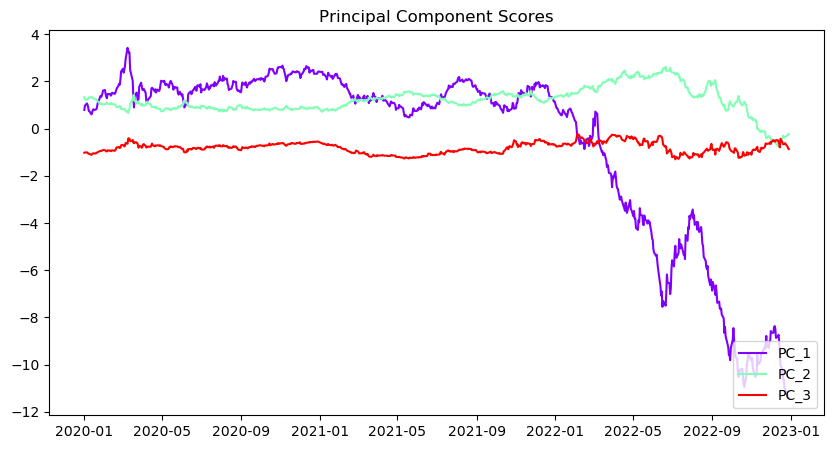

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
colors = rainbow(eig_scores.columns)

for i in components:
    plt.plot(eig_scores[i], c = colors[i], label = i)

ax.set_title ("Principal Component Scores")
ax.legend(loc = "lower right")
plt.show()

In [5]:
lag = 10

/home/bernhard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


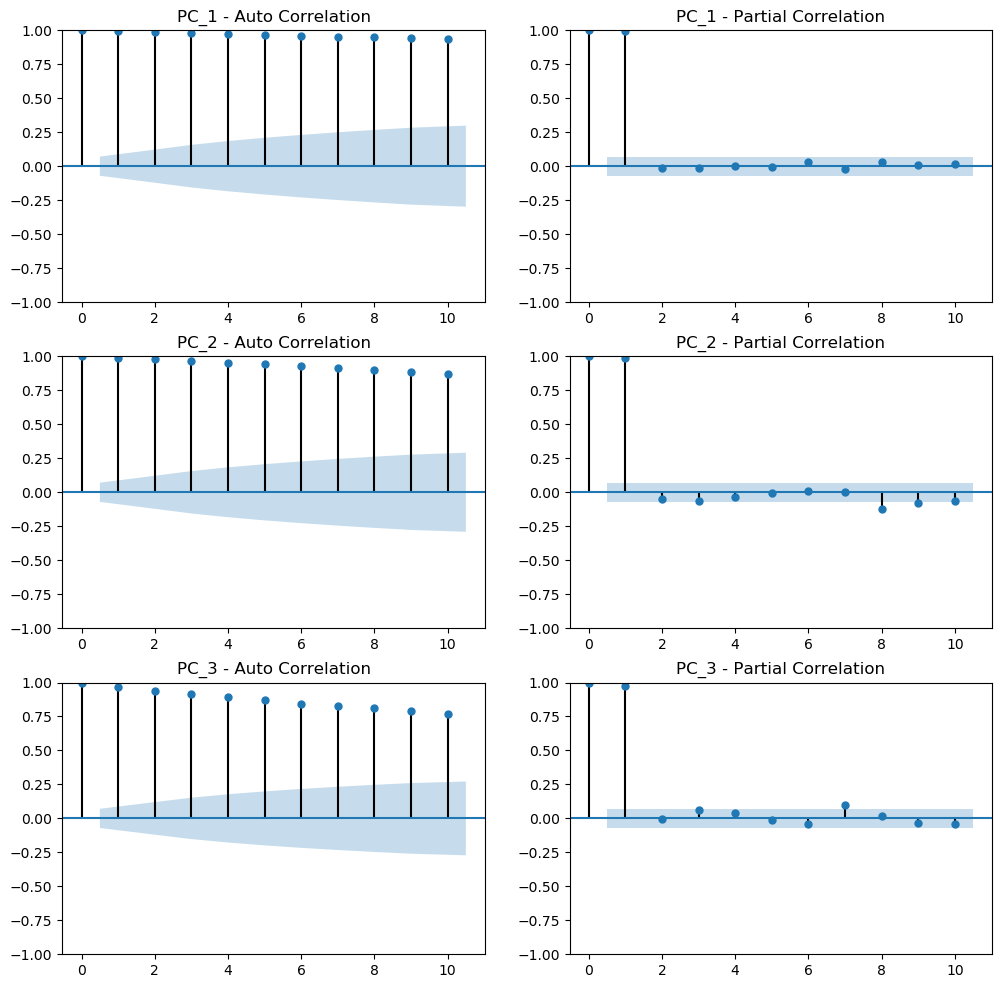

In [6]:
fig, ax = plt.subplots(nrows=pca_full.k, ncols=2, figsize=(12, 4*pca_full.k))

for i,j in enumerate (components):
    plot_acf (eig_scores[j], lags= lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(eig_scores[j], lags= lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

In [7]:
periods = 1

eig_scores_diff = eig_scores.diff(periods).iloc[periods:].add_suffix("_diff")
eig_scores_diff.head()

,PC_1_diff,PC_2_diff,PC_3_diff
DATE,,,
2020-01-03,0.182719,-0.096181,0.009761
2020-01-06,0.094763,-0.024412,0.004206
2020-01-07,-0.057549,0.036926,-0.016989
2020-01-08,-0.114395,0.033963,-0.033341
2020-01-09,-0.151862,0.033505,-0.010909


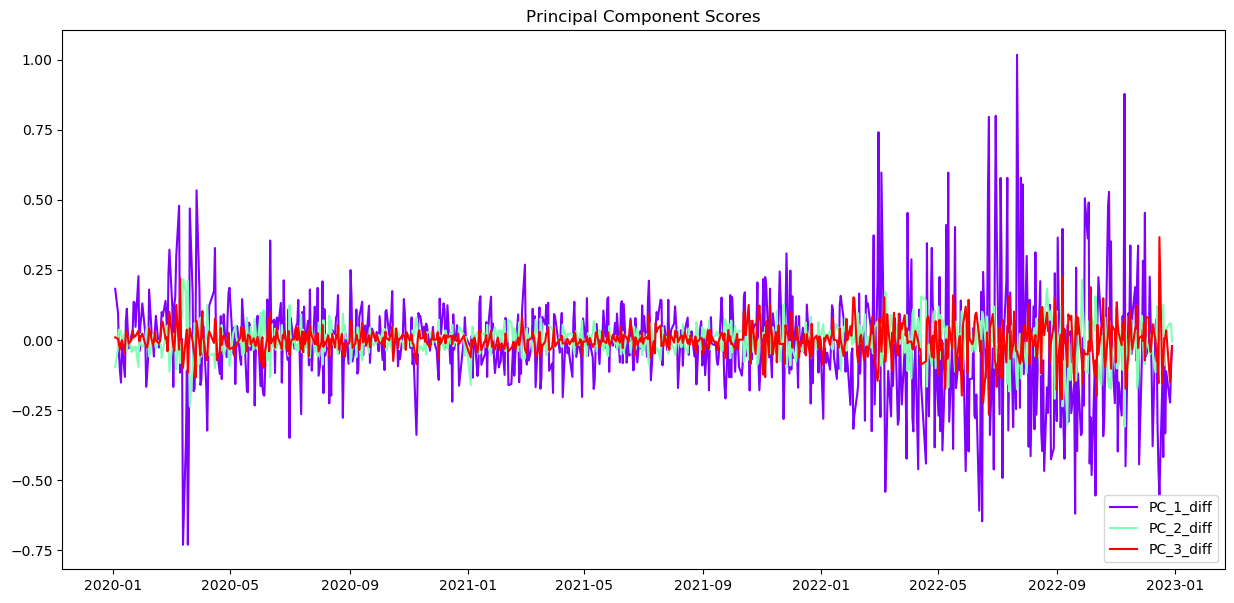

In [8]:
fig, ax = plt.subplots(figsize=(15,7))

colors = rainbow(eig_scores_diff.columns)

for i in eig_scores_diff.columns:
    plt.plot(eig_scores_diff[i], c=colors[i], label=i)

ax.set_title ("Principal Component Scores")
ax.legend(loc = "lower right")
plt.show()

In [9]:
for i in eig_scores_diff.columns:
    print (i, adf_test(df=eig_scores_diff, col=i, alpha=0.05))

PC_1_diff {'adf_stat': -17.906, 'p_val': 0.0, 'threshold': -2.8653, 'stationary': 'yes'}
PC_2_diff {'adf_stat': -7.4669, 'p_val': 0.0, 'threshold': -2.8654, 'stationary': 'yes'}
PC_3_diff {'adf_stat': -12.8223, 'p_val': 0.0, 'threshold': -2.8653, 'stationary': 'yes'}


/home/bernhard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


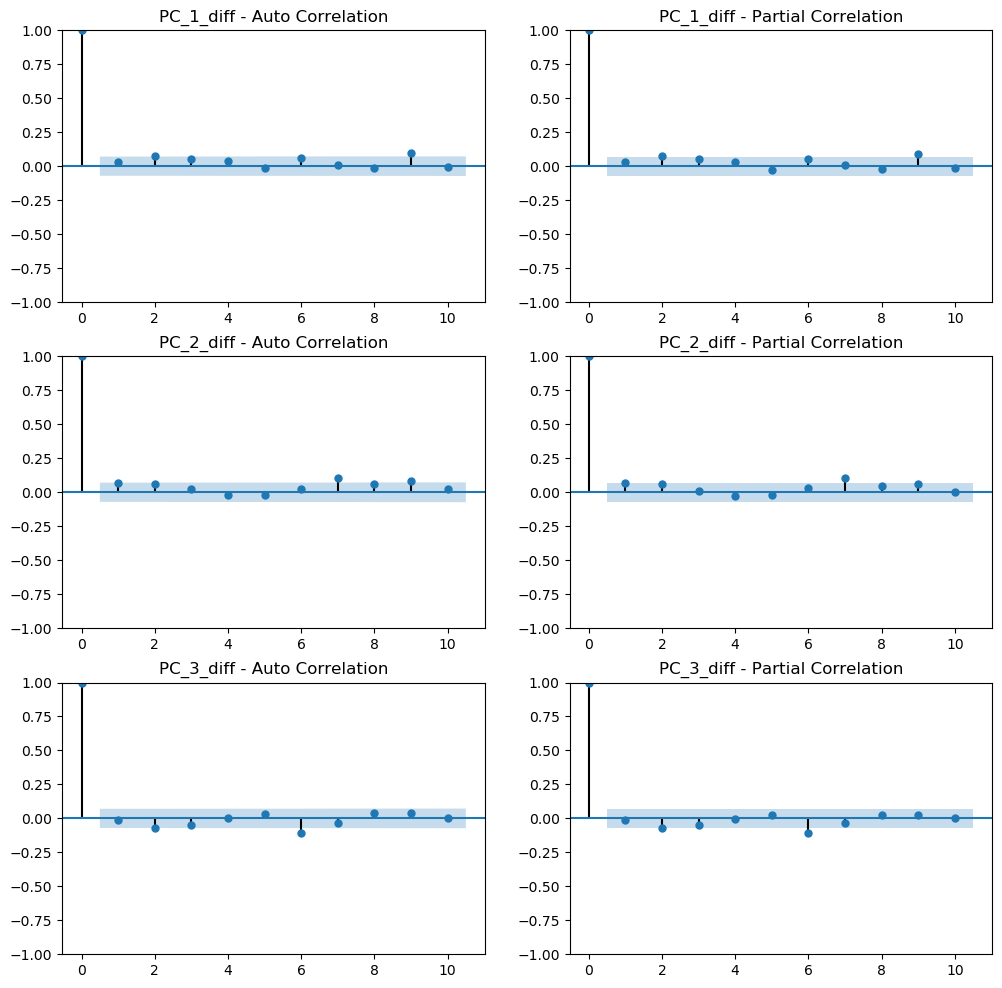

In [10]:
fig, ax = plt.subplots(nrows=pca_full.k, ncols=2, figsize=(12, 4*pca_full.k))

for i,j in enumerate (eig_scores_diff.columns):
    plot_acf (eig_scores_diff[j], lags=lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(eig_scores_diff[j], lags=lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

### Model
***

In [12]:
eig_scores_diff

,PC_1_diff,PC_2_diff,PC_3_diff
DATE,,,
2020-01-03,0.182719,-0.096181,0.009761
2020-01-06,0.094763,-0.024412,0.004206
2020-01-07,-0.057549,0.036926,-0.016989
2020-01-08,-0.114395,0.033963,-0.033341
2020-01-09,-0.151862,0.033505,-0.010909
...,...,...,...
2022-12-22,-0.332892,-0.001175,0.005514
2022-12-23,-0.111589,0.040350,0.034395
2022-12-27,-0.222925,0.060799,-0.151223


In [114]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

In [25]:
eig_scores_diff = eig_scores_diff.asfreq('b').fillna(method='ffill')

In [170]:
def get_significant_lags(mdl, alpha):
    lags = (mdl.pvalues<alpha).reset_index(drop=True)
    lags = lags[lags].index
    return lags

def predict(s: pd.Series, alpha: float):

    mdl = AutoReg(s, lags=10).fit()
    lags = get_significant_lags(mdl=mdl, alpha=alpha)
    mdl = AutoReg(s, lags=lags).fit()

    pred = mdl.predict(start=len(s), end=len(s))
    
    return (
        pred.index[0], 
        pred.values[0]
    )

def predict_all(s: pd.Series, alpha=0.05):
    pred = dict()

    for i in range(100, 400):
        date, val = predict(s=s.iloc[:i], alpha=alpha)
        pred[date] = val

    return pd.Series(pred)

In [171]:
predict_all(s=eig_scores_diff["PC_1_diff"], alpha=0.05)

2020-05-22   -0.069747
2020-05-25   -0.028218
2020-05-26    0.034853
2020-05-27   -0.044470
2020-05-28    0.115234
                ...   
2021-07-09   -0.009552
2021-07-12   -0.026753
2021-07-13   -0.011248
2021-07-14    0.011994
2021-07-15   -0.015471
Length: 300, dtype: float64